# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

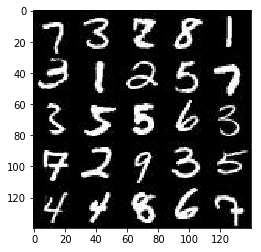

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

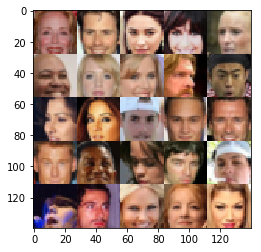

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                  name="input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="lr")

    return input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        # bn2 = x2
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        # bn3 = x3
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        shape = relu3.get_shape().as_list()
     
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    training = is_train
    output_dim = out_channel_dim
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512, activation=None, use_bias=False)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_dim = out_channel_dim
    g_model = generator(input_z, output_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z, self.lr = model_inputs(real_size[0], 
                                                              real_size[1], real_size[2],z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = 3 if data_image_mode == "RGB" else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
        
    steps = 0
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # TODO: Train Model
                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/25... Discriminator Loss: 0.5176... Generator Loss: 3.1381


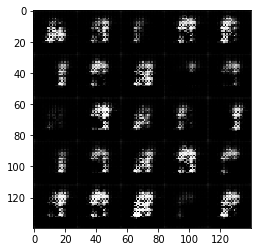

Epoch 1/25... Discriminator Loss: 0.9219... Generator Loss: 1.4703


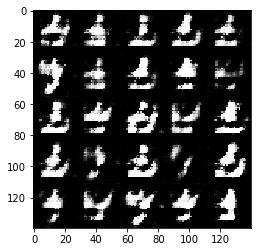

Epoch 1/25... Discriminator Loss: 0.8244... Generator Loss: 1.7236


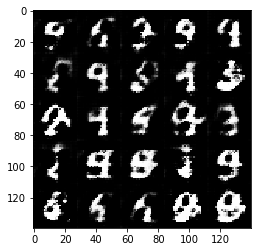

Epoch 1/25... Discriminator Loss: 0.8212... Generator Loss: 1.6562


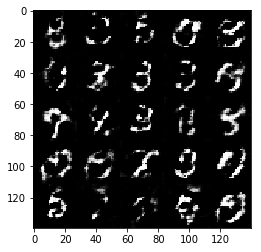

Epoch 2/25... Discriminator Loss: 0.8854... Generator Loss: 1.3858


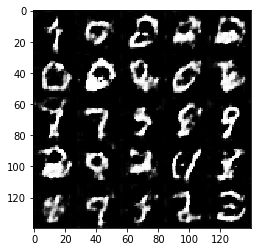

Epoch 2/25... Discriminator Loss: 1.0537... Generator Loss: 1.7437


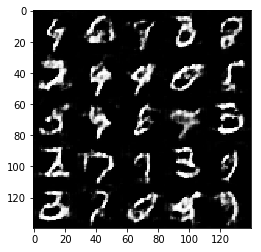

Epoch 2/25... Discriminator Loss: 1.1614... Generator Loss: 0.7272


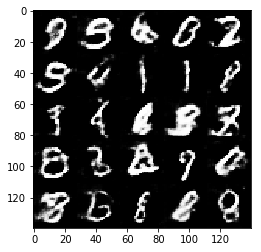

Epoch 2/25... Discriminator Loss: 0.9220... Generator Loss: 1.2084


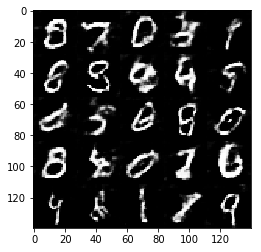

Epoch 2/25... Discriminator Loss: 1.1490... Generator Loss: 1.8693


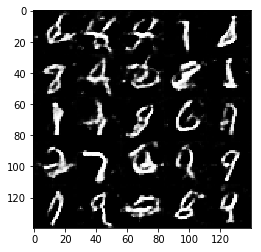

Epoch 3/25... Discriminator Loss: 0.8416... Generator Loss: 1.4372


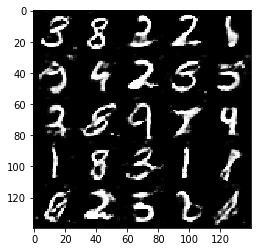

Epoch 3/25... Discriminator Loss: 0.9087... Generator Loss: 1.0760


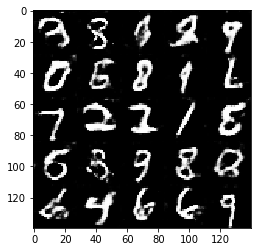

Epoch 3/25... Discriminator Loss: 1.0264... Generator Loss: 0.9322


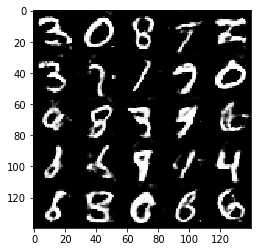

Epoch 3/25... Discriminator Loss: 0.9646... Generator Loss: 1.2965


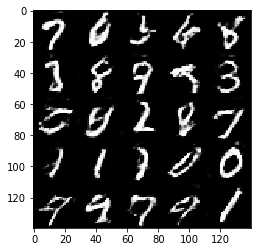

Epoch 3/25... Discriminator Loss: 2.6433... Generator Loss: 0.1823


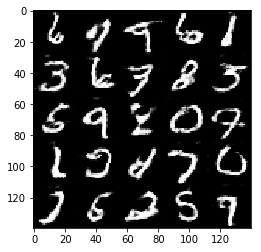

Epoch 4/25... Discriminator Loss: 0.8082... Generator Loss: 1.2942


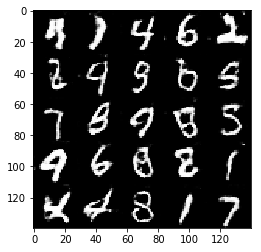

Epoch 4/25... Discriminator Loss: 1.2006... Generator Loss: 0.6699


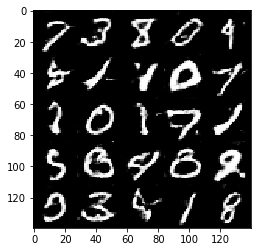

Epoch 4/25... Discriminator Loss: 1.5546... Generator Loss: 0.4923


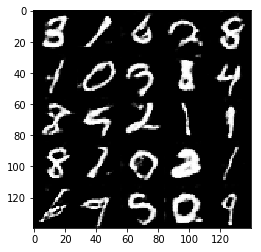

Epoch 4/25... Discriminator Loss: 0.9390... Generator Loss: 1.7163


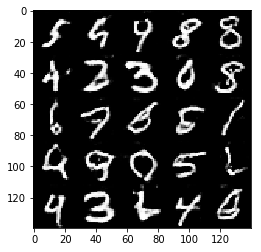

Epoch 5/25... Discriminator Loss: 1.1534... Generator Loss: 0.6990


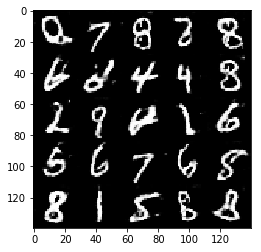

Epoch 5/25... Discriminator Loss: 0.9702... Generator Loss: 2.6347


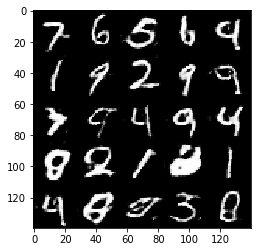

Epoch 5/25... Discriminator Loss: 1.1929... Generator Loss: 0.7342


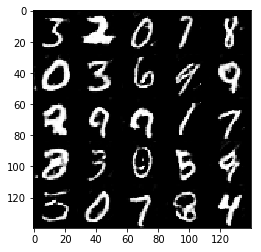

Epoch 5/25... Discriminator Loss: 0.8601... Generator Loss: 1.3228


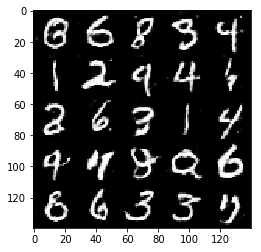

Epoch 5/25... Discriminator Loss: 1.0324... Generator Loss: 0.8655


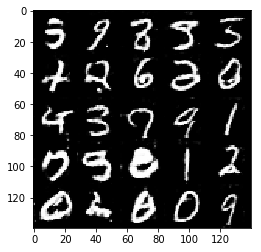

Epoch 6/25... Discriminator Loss: 0.9014... Generator Loss: 1.1434


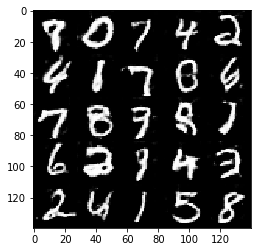

Epoch 6/25... Discriminator Loss: 0.9150... Generator Loss: 1.0237


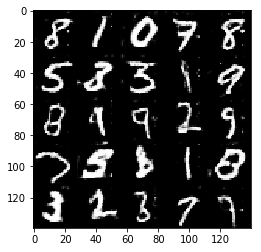

Epoch 6/25... Discriminator Loss: 0.8377... Generator Loss: 1.1478


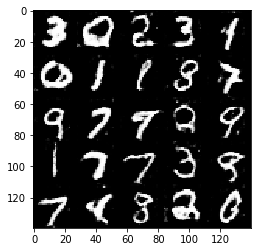

Epoch 6/25... Discriminator Loss: 0.6278... Generator Loss: 1.7460


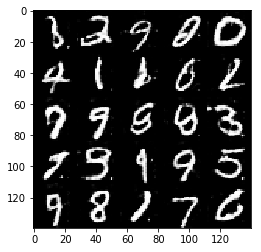

Epoch 6/25... Discriminator Loss: 1.3816... Generator Loss: 0.6011


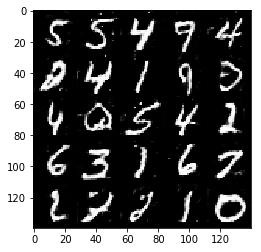

Epoch 7/25... Discriminator Loss: 0.8566... Generator Loss: 1.3459


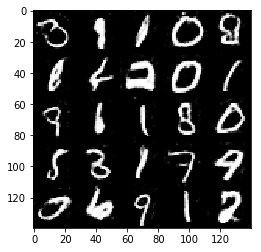

Epoch 7/25... Discriminator Loss: 0.7480... Generator Loss: 2.3887


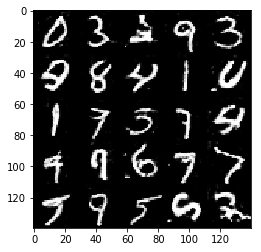

Epoch 7/25... Discriminator Loss: 1.5351... Generator Loss: 0.5752


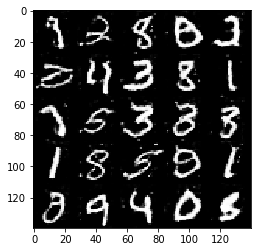

Epoch 7/25... Discriminator Loss: 1.0056... Generator Loss: 0.9704


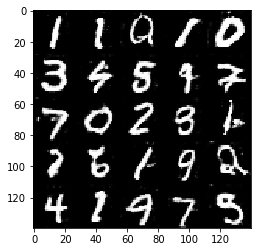

Epoch 8/25... Discriminator Loss: 0.8303... Generator Loss: 1.3399


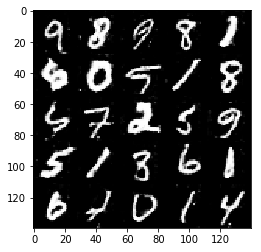

Epoch 8/25... Discriminator Loss: 0.8088... Generator Loss: 1.4266


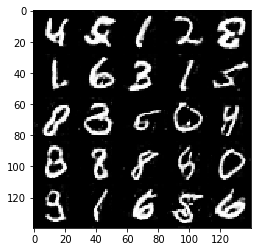

Epoch 8/25... Discriminator Loss: 0.9314... Generator Loss: 1.0150


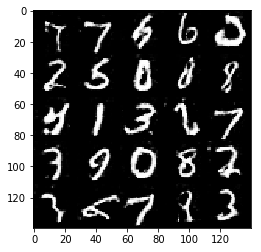

Epoch 8/25... Discriminator Loss: 0.6453... Generator Loss: 1.6149


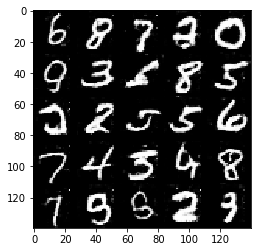

Epoch 8/25... Discriminator Loss: 0.5896... Generator Loss: 1.7622


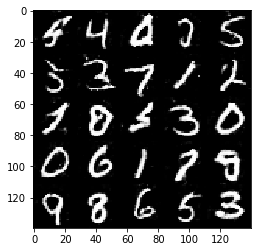

Epoch 9/25... Discriminator Loss: 0.8041... Generator Loss: 1.2227


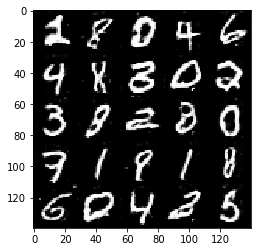

Epoch 9/25... Discriminator Loss: 0.9746... Generator Loss: 0.9776


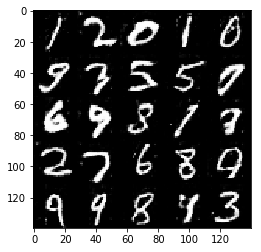

Epoch 9/25... Discriminator Loss: 0.7630... Generator Loss: 1.5751


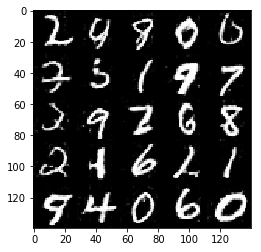

Epoch 9/25... Discriminator Loss: 0.8774... Generator Loss: 1.1620


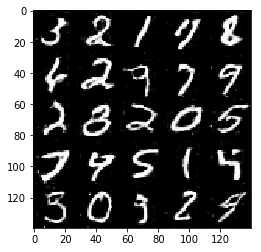

Epoch 9/25... Discriminator Loss: 0.8611... Generator Loss: 1.1182


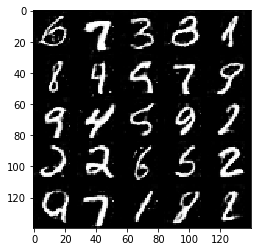

Epoch 10/25... Discriminator Loss: 1.2597... Generator Loss: 0.7300


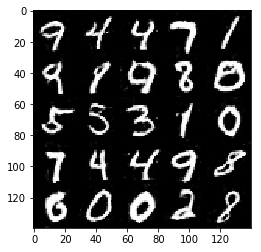

Epoch 10/25... Discriminator Loss: 0.5635... Generator Loss: 1.8626


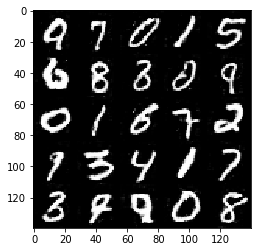

Epoch 10/25... Discriminator Loss: 0.6819... Generator Loss: 1.5081


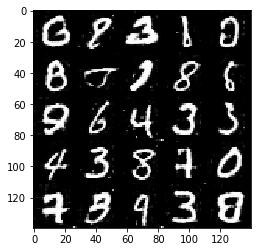

Epoch 10/25... Discriminator Loss: 0.7202... Generator Loss: 1.4277


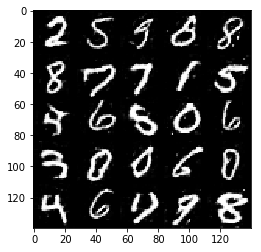

Epoch 11/25... Discriminator Loss: 0.6909... Generator Loss: 1.4429


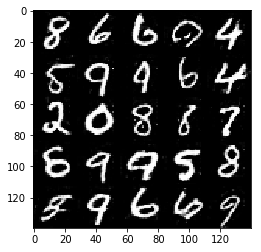

Epoch 11/25... Discriminator Loss: 0.7719... Generator Loss: 2.1223


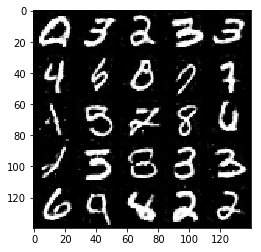

Epoch 11/25... Discriminator Loss: 1.3393... Generator Loss: 0.6157


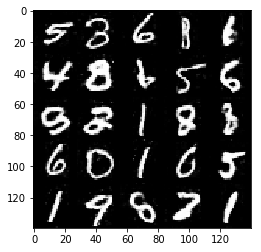

Epoch 11/25... Discriminator Loss: 0.7238... Generator Loss: 1.3622


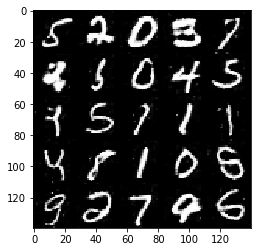

Epoch 11/25... Discriminator Loss: 2.2098... Generator Loss: 0.3748


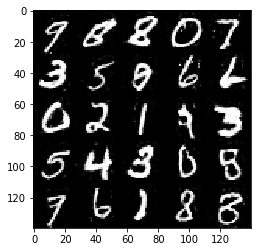

Epoch 12/25... Discriminator Loss: 0.9617... Generator Loss: 1.0176


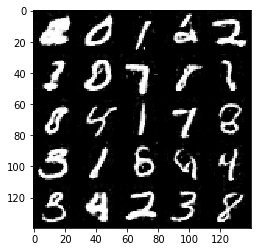

Epoch 12/25... Discriminator Loss: 0.6688... Generator Loss: 2.5618


KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 25

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/100... Discriminator Loss: 0.4684... Generator Loss: 2.6640


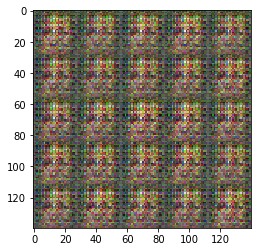

Epoch 1/100... Discriminator Loss: 0.4043... Generator Loss: 3.3894


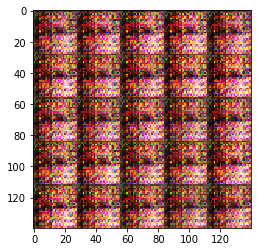

Epoch 1/100... Discriminator Loss: 0.7287... Generator Loss: 1.7851


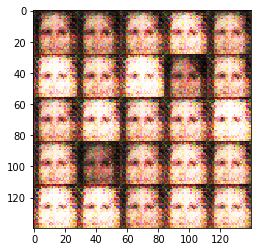

Epoch 1/100... Discriminator Loss: 0.5599... Generator Loss: 2.1238


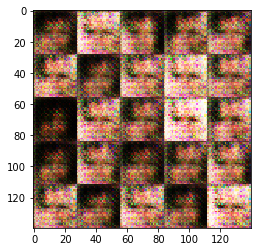

Epoch 1/100... Discriminator Loss: 0.6789... Generator Loss: 1.9493


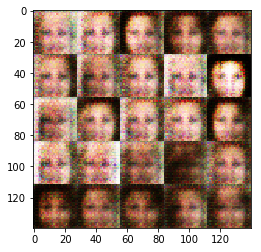

Epoch 1/100... Discriminator Loss: 0.8086... Generator Loss: 1.4608


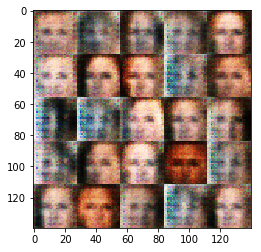

Epoch 1/100... Discriminator Loss: 0.9654... Generator Loss: 1.1719


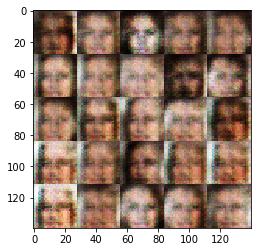

Epoch 2/100... Discriminator Loss: 0.9486... Generator Loss: 1.7318


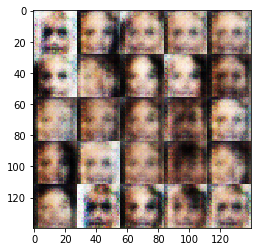

Epoch 2/100... Discriminator Loss: 1.0048... Generator Loss: 1.2491


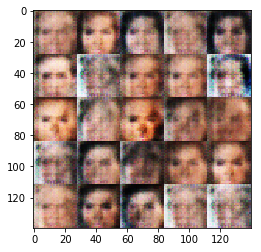

Epoch 2/100... Discriminator Loss: 1.3132... Generator Loss: 0.7647


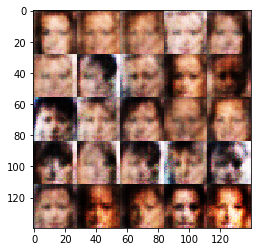

Epoch 2/100... Discriminator Loss: 1.2597... Generator Loss: 2.2317


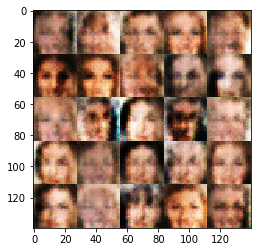

Epoch 2/100... Discriminator Loss: 0.9758... Generator Loss: 1.2610


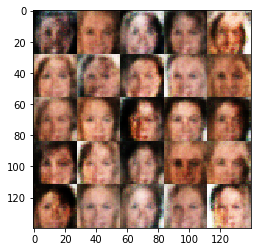

Epoch 2/100... Discriminator Loss: 0.9250... Generator Loss: 1.7236


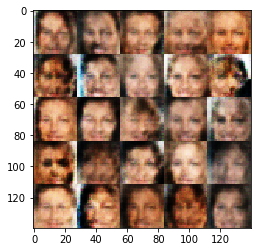

Epoch 2/100... Discriminator Loss: 1.0758... Generator Loss: 1.1808


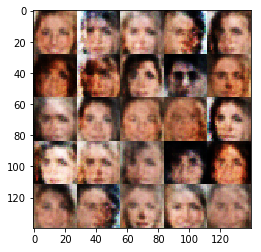

Epoch 2/100... Discriminator Loss: 0.9273... Generator Loss: 1.3377


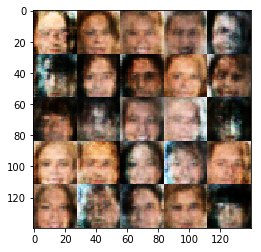

Epoch 3/100... Discriminator Loss: 1.1451... Generator Loss: 0.9682


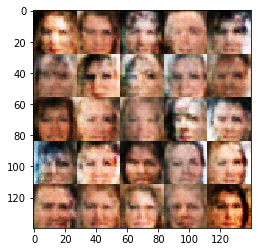

Epoch 3/100... Discriminator Loss: 1.1150... Generator Loss: 0.9753


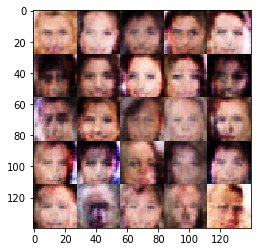

Epoch 3/100... Discriminator Loss: 1.1665... Generator Loss: 0.8174


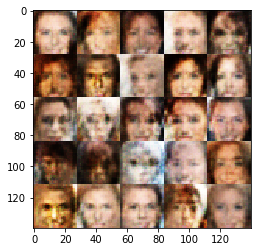

Epoch 3/100... Discriminator Loss: 1.0370... Generator Loss: 1.1644


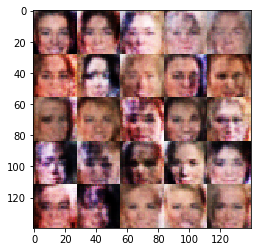

Epoch 3/100... Discriminator Loss: 1.1259... Generator Loss: 0.8872


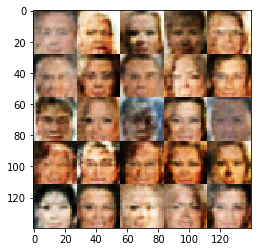

Epoch 3/100... Discriminator Loss: 1.3716... Generator Loss: 0.6445


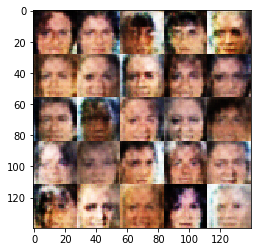

Epoch 3/100... Discriminator Loss: 1.1373... Generator Loss: 0.9800


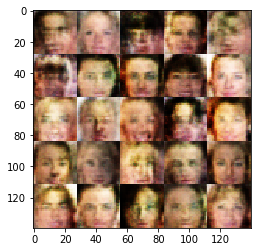

Epoch 3/100... Discriminator Loss: 1.0631... Generator Loss: 0.9342


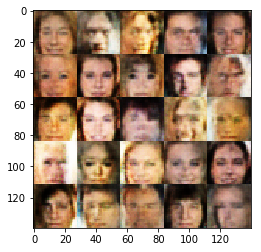

Epoch 4/100... Discriminator Loss: 1.0089... Generator Loss: 1.2296


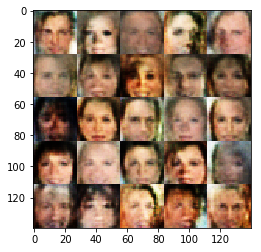

Epoch 4/100... Discriminator Loss: 1.1912... Generator Loss: 1.2003


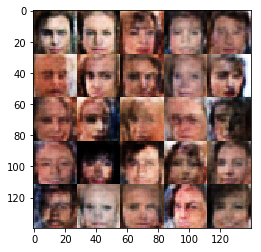

Epoch 4/100... Discriminator Loss: 1.0980... Generator Loss: 1.0287


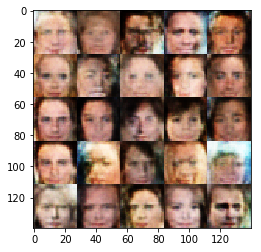

Epoch 4/100... Discriminator Loss: 1.0601... Generator Loss: 1.1791


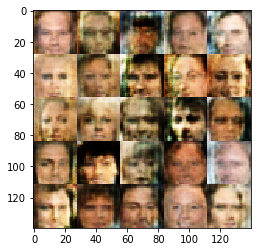

Epoch 4/100... Discriminator Loss: 1.0236... Generator Loss: 1.3088


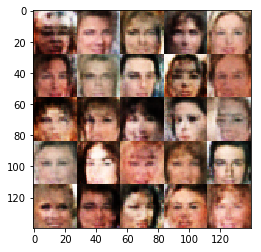

Epoch 4/100... Discriminator Loss: 1.0384... Generator Loss: 0.9599


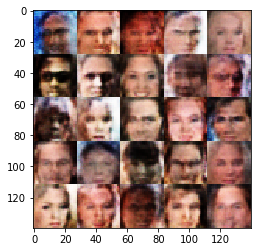

Epoch 4/100... Discriminator Loss: 0.9838... Generator Loss: 1.1379


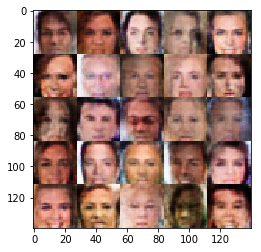

Epoch 4/100... Discriminator Loss: 1.5622... Generator Loss: 2.3590


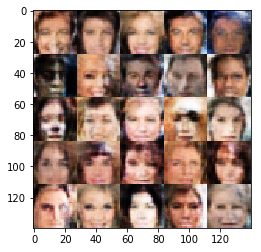

Epoch 5/100... Discriminator Loss: 0.8996... Generator Loss: 1.5282


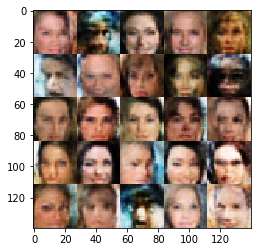

Epoch 5/100... Discriminator Loss: 1.0410... Generator Loss: 0.9163


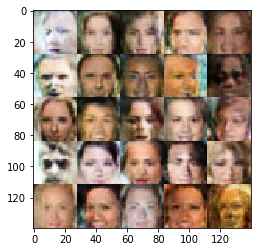

Epoch 5/100... Discriminator Loss: 1.0220... Generator Loss: 1.5409


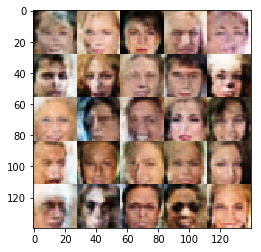

Epoch 5/100... Discriminator Loss: 1.0187... Generator Loss: 1.1446


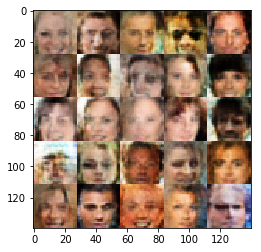

Epoch 5/100... Discriminator Loss: 1.0281... Generator Loss: 1.1708


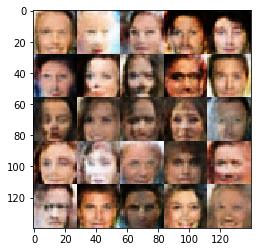

Epoch 5/100... Discriminator Loss: 1.1838... Generator Loss: 0.8477


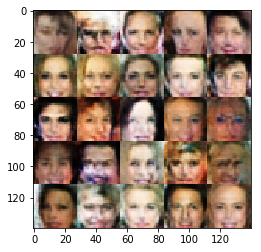

Epoch 5/100... Discriminator Loss: 0.9711... Generator Loss: 1.3306


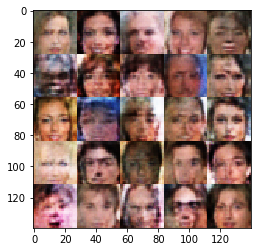

Epoch 5/100... Discriminator Loss: 1.0223... Generator Loss: 1.0956


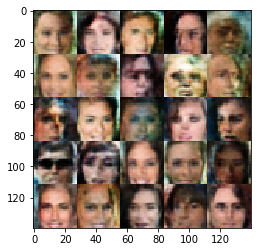

Epoch 6/100... Discriminator Loss: 0.9174... Generator Loss: 1.3833


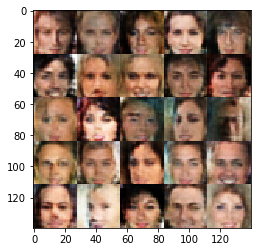

Epoch 6/100... Discriminator Loss: 0.9829... Generator Loss: 1.1679


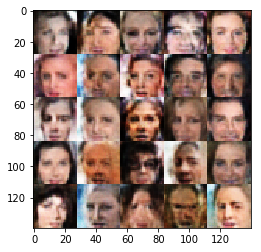

Epoch 6/100... Discriminator Loss: 1.0578... Generator Loss: 1.6861


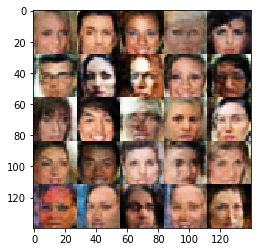

Epoch 6/100... Discriminator Loss: 0.9684... Generator Loss: 1.2396


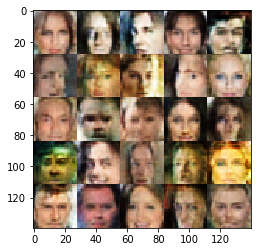

Epoch 6/100... Discriminator Loss: 1.0345... Generator Loss: 0.9582


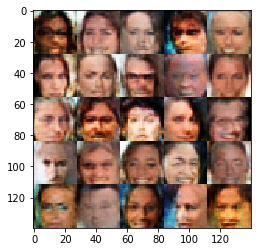

Epoch 6/100... Discriminator Loss: 0.9993... Generator Loss: 1.4001


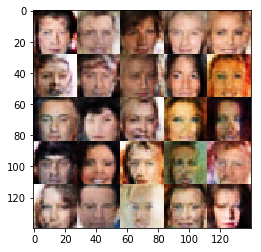

Epoch 6/100... Discriminator Loss: 1.0861... Generator Loss: 1.5934


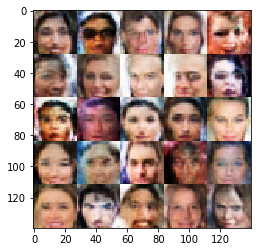

KeyboardInterrupt: 

In [15]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.